## Wav2Vec Torch model

In [59]:
# %matplotlib inline

import os

import IPython
import matplotlib
import matplotlib.pyplot as plt
import requests
import torch
import torchaudio

matplotlib.rcParams["figure.figsize"] = [16.0, 4.8]

torch.random.manual_seed(42)
device = torch.device("cpu")

print(torch.__version__)
print(torchaudio.__version__)
print(device)

SPEECH_FILE = "male.wav"

1.13.1+cu116
0.13.1+cu116
cpu


In [ ]:
# importing all necessary symbols and outputting speech rate
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H

print("rate:", bundle.sample_rate)

print("symbols:", bundle.get_labels())

rate: 16000
symbols: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [ ]:
# importing the model to device
model = bundle.get_model().to(device)

print(model.__class__)

<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>


In [ ]:
# waveform, sample_rate = torchaudio.load(SPEECH_FILE)
waveform, sample_rate = torchaudio.load('male.wav')

waveform = waveform.to(device)

if sample_rate != bundle.sample_rate:
    waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)

IPython.display.Audio('male.wav')

In [ ]:
# predicting present symbols in an audio
with torch.inference_mode():
    emission, _ = model(waveform)

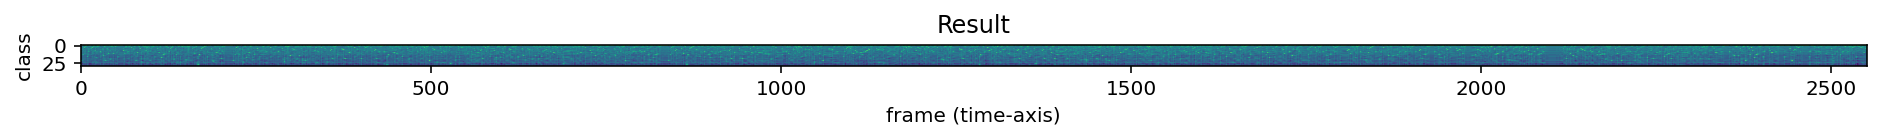

present symbols: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [ ]:
# Classification result
plt.imshow(emission[0].cpu().T)
plt.title("Result")
plt.xlabel("frame (time-axis)")
plt.ylabel("class")
plt.show()
print("present symbols:", bundle.get_labels())

In [ ]:
# greedy decoding algorithm
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emission: torch.Tensor) -> str:
        """Given a sequence emission over labels, get the best path string
        Args:
          emission (Tensor): Logit tensors. Shape `[num_seq, num_label]`.

        Returns:
          str: The resulting transcript
        """
        indices = torch.argmax(emission, dim=-1)  # [num_seq,]
        indices = torch.unique_consecutive(indices, dim=-1)
        indices = [i for i in indices if i != self.blank]
        return "".join([self.labels[i] for i in indices])

In [ ]:
# decoding the .wav file
decoder = GreedyCTCDecoder(labels=bundle.get_labels())
transcript = decoder(emission[0])

In [60]:
# outputting the results
print(transcript)
IPython.display.Audio('male.wav')

BUT|WHAT|IF|SOMEBODY|DECIDES|TO|BREAK|IT|BE|CAREFUL|THAT|YOU|KEEP|ADEQUATE|COVERAGE|BUT|LOOK|FOR|PLACES|TO|SAVE|MONEY|MAYBE|IT'S|TAKING|LONGER|TO|GET|THINGS|SQUARED|AWAY|THAN|THE|BANKERS|EXPECTED|HIRING|THE|WIFE|FOR|ONCE|COMPANY|MAY|WHIN|HER|TAXATED|RETIREMENT|AND|COME|THE|BOOST|IS|HELPFUL|BUT|INADEQUATE|NEW|SELF|DESAVING|RAGS|ARE|HURDLY|TOSSED|ON|THE|TWO|NAKED|BONES|WHAT|A|DISCUSSION|CAN|ENSUE|WHEN|THE|TITLE|OF|THIS|TYPE|OF|SONG|IS|IN|QUESTION|THERE|IS|NO|DAWING|OR|WAXING|OR|GASSING|NEETE|PAPER|WEIGHT|MAY|BE|PERSONALIZED|ON|BACK|WHILE|CLAY|IS|LEATHER|HARD|PLACE|WORK|ON|A|FLAT|SURFACE|AND|SMOOTH|OUT|THE|SIMPLEST|KIND|OF|SEPARATE|SYSTEM|USES|A|SINGLE|SELF|CONTAINED|UNIT|THE|OLD|SHOP|AUT|IT|STILL|HOLDS|A|GOOD|MECHANIC|IS|USUALLY|A|BAD|BOSS|O|FIGURES|WOULD|GO|HIRER|AN|LATER|YEARS|SOME|MAKE|BEAUTIFUL|CHAIRS|CABINETS|CHEST|DOW|HOUSES|ET|CETERA|


## Making a model in one run

In [ ]:
# working with live data
audio = 'oh-yeah-everything-is-fine.wav'
def asr(audio = 'oh-yeah-everything-is-fine.wav'):

  waveform, sample_rate = torchaudio.load(audio)

  waveform = waveform.to(device)

  if sample_rate != bundle.sample_rate:
      waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)

  with torch.inference_mode():
      emission, _ = model(waveform)

  decoder = GreedyCTCDecoder(labels=bundle.get_labels())
  transcript = decoder(emission[0])

  print(transcript)


asr()
IPython.display.Audio(audio)


OH|YAT|EVERYTHING'S|FINE|


In [61]:
# creating simple audio recorder with an option to choose duration
from IPython.display import Javascript
from google.colab import output
from base64 import b64decode

RECORD = """
const sleep = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec, filename='test.wav'):
  display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec * 1000))
  b = b64decode(s.split(',')[1])
  with open(filename, 'wb+') as f:
    f.write(b)

audio = 'test.wav'
second = 7
print(f"Speak to your microphone {second} sec...")
record(second, audio)
print("Done!")


asr(audio)
IPython.display.Audio(audio)

Speak to your microphone 7 sec...


<IPython.core.display.Javascript object>

Done!
HELLO|EVERY|ONE|MY|NAME|IS|SLAMBEC|HOW|ARE|YOU|DOING|


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


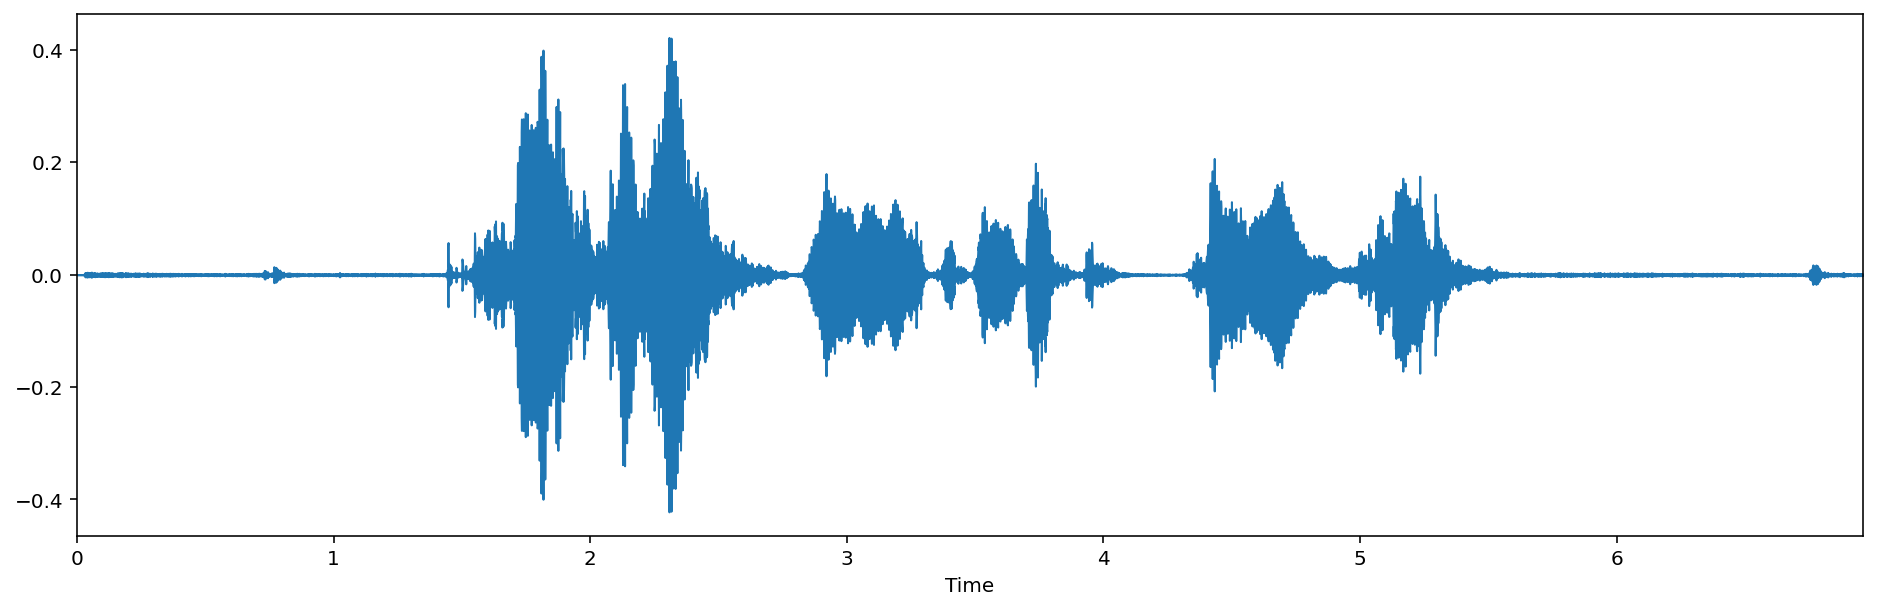

In [62]:
# wave plotting
import librosa
import librosa.display
speech, rate = librosa.load(audio, sr=16000)
librosa.display.waveplot(speech, sr=rate)


[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

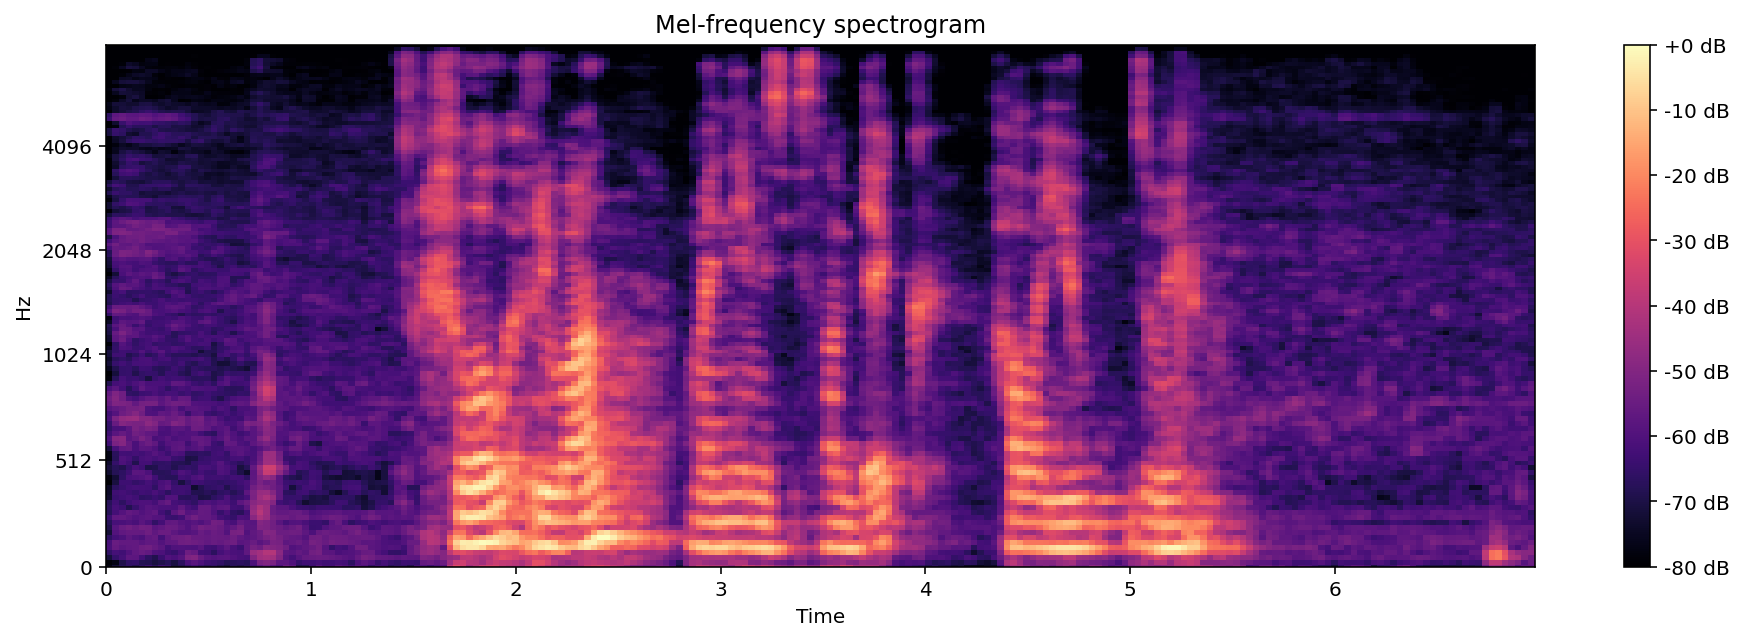

In [63]:
# melspectrogram
import numpy as np
import matplotlib.pyplot as plt


librosa.feature.melspectrogram(y=speech, sr=rate)

D = np.abs(librosa.stft(speech))**2
S = librosa.feature.melspectrogram(y=speech, sr=rate, n_mels=128, fmax=8000)

fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=rate, fmax=8000, ax=ax)

fig.colorbar(img, ax=ax, format='%+2.0f dB')h

ax.set(title='Mel-frequency spectrogram')

## Trying ESPNET2 to Automatic Speech Recognition

In [ ]:
!pip install -q espnet_model_zoo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 KB 14.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 KB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 KB 5.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 KB 12.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Prepar

In [ ]:
lang = 'en'
fs = 16000 #@param {type:"integer"}
tag = 'Shinji Watanabe/spgispeech_asr_train_asr_conformer6_n_fft512_hop_length256_raw_en_unnorm_bpe5000_valid.acc.ave' #@param ["Shinji Watanabe/spgispeech_asr_train_asr_conformer6_n_fft512_hop_length256_raw_en_unnorm_bpe5000_valid.acc.ave", "kamo-naoyuki/librispeech_asr_train_asr_conformer6_n_fft512_hop_length256_raw_en_bpe5000_scheduler_confwarmup_steps40000_optim_conflr0.0025_sp_valid.acc.ave"] {type:"string"}

In [ ]:
import time
import string
from espnet_model_zoo.downloader import ModelDownloader
from espnet2.bin.asr_inference import Speech2Text


d = ModelDownloader()

speech2text = Speech2Text(
    **d.download_and_unpack(tag),
    device="cpu",
    minlenratio=0.0,
    maxlenratio=0.0,
    ctc_weight=0.3,
    beam_size=10,
    batch_size=0,
    nbest=1
)

def text_normalizer(text):
    text = text.upper()
    return text.translate(str.maketrans('', '', string.punctuation))

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package cmudict to /root/nltk_data...
[nltk_data]   Unzipping corpora/cmudict.zip.
https://zenodo.org/record/4585558/files/asr_train_asr_conformer6_n_fft512_hop_length256_raw_en_unnorm_bpe5000_valid.acc.ave.zip?download=1: 100%|██████████| 772M/772M [00:32<00:00, 24.9MB/s]


In [64]:
nbests = speech2text(speech)
text, *_ = nbests[0]

print(f"ESPNET_model_zoo: {text_normalizer(text)}")     

ESPNET_model_zoo: THANK YOU EVERYONE MY NAME IS SCHLUMBERGER HOW ARE YOU DOING
